#### Dataset:
    1. Commercial Flight US - January 2024
    2. City Code
    3. Airlines Code (IATA)

In [2]:
import pandas as pd
import numpy as np

data1 = "T_ONTIME_MARKETING.csv"
data2 = "Consumer_Airfare_Report__Table_2_-_Top_1_000_City-Pair_Markets_20240827.csv"
data3 = "airlines.dat"

df1 = pd.read_csv(data1, low_memory=False)
df2 = pd.read_csv(data2)
df3 = pd.read_csv(data3, encoding='utf8')
df3.columns = ["airline_id","name","alias","iata","icao","callsign","country","active"]

#Cleaning flight table (Primary key: 'FL_DATE', 'OP_UNIQUE_CARRIER','OP_CARRIER_FL_NUM','ORIGIN_CITY_MARKET_ID','DEP_TIME')
flight = df1[['FL_DATE','OP_UNIQUE_CARRIER','OP_CARRIER_FL_NUM','ORIGIN_CITY_MARKET_ID','DEST_CITY_MARKET_ID',
              'CRS_DEP_TIME','DEP_TIME', 'DEP_DELAY', 'ARR_TIME', 'ARR_DELAY','ARR_DELAY_NEW',
           'CANCELLED','DISTANCE']]

# Cleaning city table (Primary key: citymarketid)
#city = df2[(df2["Year"]==2023) & (df2["quarter"]==4)]
city = df2[(df2["Year"]==2024)].reset_index()
city = city[['citymarketid', 'city','markets','cur_passengers','cur_fare']]
city.columns = ['citymarketid', 'city_name','markets','cur_passengers','cur_fare']
city["state"]=city['city_name'].str.split(', ').str[1].str[:2]
city["city_name"]=city['city_name'].str.split(', ').str[0]
city = city[['citymarketid', 'city_name', 'state','markets','cur_passengers','cur_fare']]

# Cleaning airlines table (Primary key: iata)
airlines = df3.drop_duplicates(subset=['iata'])
airlines = airlines.drop(0)
airlines = airlines.drop(1).reset_index()
airlines = airlines[['name','iata','country']]

In [4]:
airlines

,name,iata,country
0,1Time Airline,1T,South Africa
1,40-Mile Air,Q5,United States
2,Ansett Australia,AN,Australia
3,Abacus International,1B,Singapore
4,Abelag Aviation,W9,Belgium
...,...,...,...
1115,Atlantic Air Cargo,K3,United States
1116,Dummy,0E,France
1117,All America BOPY,0P,Paraguay
1118,Air Andaman (2Y),2Y,Thailand


In [6]:
#Check merging data between flight and city
flight["citymarketid"]=flight["ORIGIN_CITY_MARKET_ID"]
merge1 = pd.merge(city, flight, on='citymarketid', how='inner')
merge1.city_name.value_counts().head()

/var/folders/23/6fv5c4zd0j7gt5pr6qbdnznh0000gn/T/ipykernel_18118/1205323486.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight["citymarketid"]=flight["ORIGIN_CITY_MARKET_ID"]


city_name
New York City        35344
Dallas/Fort Worth    29780
Chicago              28885
Atlanta              26363
Washington           24881
Name: count, dtype: int64

In [8]:
#Check merging data between flight and airlines
flight2 = flight.rename(columns= {'OP_UNIQUE_CARRIER':'iata'})
flight2 = flight2.drop_duplicates(subset=['iata'])
merge2 = pd.merge(airlines, flight2, on='iata', how='inner')
merge2[["name","iata","country"]]

,name,iata,country
0,American Airlines,AA,United States
1,Allegiant Air,G4,United States
2,Air Wisconsin,ZW,United States
3,Alaska Airlines,AS,ALASKA
4,American Eagle Airlines,MQ,United States
5,Capital Cargo International Airlines,PT,United States
6,Comair,OH,United States
7,CommutAir,C5,United States
8,Delta Air Lines,DL,United States
9,Frontier Airlines,F9,United States


In [10]:
# Checking flight data

#flight['OP_UNIQUE_CARRIER','dep_delay','departure_delay']
#flight.duplicated(subset=['FL_DATE', 'OP_UNIQUE_CARRIER','OP_CARRIER_FL_NUM','ORIGIN_CITY_MARKET_ID',"DEP_TIME"]).sum()
#flight[['FL_DATE', 'OP_UNIQUE_CARRIER','OP_CARRIER_FL_NUM','ORIGIN_CITY_MARKET_ID','DEP_TIME']]
flight.OP_UNIQUE_CARRIER.value_counts().head(5)

OP_UNIQUE_CARRIER
WN    115389
AA     77346
DL     74384
UA     58855
OO     56811
Name: count, dtype: int64

In [12]:
# Checking city data
city.head(10).sort_values(by='markets', ascending=False)

,citymarketid,city_name,state,markets,cur_passengers,cur_fare
7,31703,New York City,NY,75,14874350,249.34
3,30466,Phoenix,AZ,67,6562330,238.13
5,32211,Las Vegas,NV,67,6919380,225.19
9,33195,Tampa,FL,55,4252060,207.25
6,31057,Charlotte,NC,36,2231190,254.87
8,31066,Columbus,OH,21,1063340,229.50
1,30140,Albuquerque,NM,15,525360,225.86
4,33316,Omaha,NE,14,494750,232.86
2,30257,Albany,NY,5,199780,213.31
0,34321,Portland,ME,3,101980,196.99


In [14]:
# Delayed Analysis

#Delays are divided into three categories, namely:
# 1. "on time or small delay" (up to 15 minutes delay)
# 2. "Medium delay" (15 – 45 minutes delay)
# 3. "Large delay" (45 minutes delay)

# flight["departure_delay"]=flight.DEP_DELAY.apply(lambda x:0 if x<=15 else 1)
# flight["arrival_delay"]=flight.ARR_DELAY.apply(lambda x:0 if x<=15 else 1)

# Defining function for delay categorization
def delay_cat(delay):
    if pd.isnull(delay):  # Check for NaN
        return 'Cancelled'
    elif delay <= 15:
        return 'On Time'
    elif delay <= 45:
        return 'Medium Delay'
    else:
        return 'Large Delay'

flight["dep_delay_cat"] = flight["DEP_DELAY"].apply(delay_cat) 
flight["arr_delay_cat"] = flight["ARR_DELAY"].apply(delay_cat) 

/var/folders/23/6fv5c4zd0j7gt5pr6qbdnznh0000gn/T/ipykernel_18118/2811316165.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight["dep_delay_cat"] = flight["DEP_DELAY"].apply(delay_cat)
/var/folders/23/6fv5c4zd0j7gt5pr6qbdnznh0000gn/T/ipykernel_18118/2811316165.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight["arr_delay_cat"] = flight["ARR_DELAY"].apply(delay_cat)


In [16]:
# Departure Category Analysis

flight.groupby(['OP_UNIQUE_CARRIER', 'dep_delay_cat'])[['dep_delay_cat']].count().head(10)

dep_cat = flight.groupby(['OP_UNIQUE_CARRIER', 'dep_delay_cat']).size()
dep_cat = grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
dep_cat = percentage.reset_index(name='percentage')
dep_cat.head(10)

NameError: name 'grouped' is not defined

In [53]:
# Departure Delay Category Analysis

flight.groupby(['OP_UNIQUE_CARRIER', 'dep_delay_cat'])[['dep_delay_cat']].count().head(10)

dep_cat = flight.groupby(['OP_UNIQUE_CARRIER', 'dep_delay_cat']).size()


df_delay = dep_cat[~dep_cat['dep_delay_cat'].isin('Cancelled','On Time')]

KeyError: 'dep_delay_cat'

In [48]:
flight.groupby(['OP_UNIQUE_CARRIER', 'dep_delay_cat'])[['dep_delay_cat']].count().head(10)

dep_cat = flight.groupby(['OP_UNIQUE_CARRIER', 'dep_delay_cat']).size()
dep_cat

OP_UNIQUE_CARRIER  dep_delay_cat
9E                 Cancelled          671
                   Large Delay       2075
                   Medium Delay      1332
                   On Time          12894
AA                 Cancelled         1148
                                    ...  
YX                 On Time          18863
ZW                 Cancelled          318
                   Large Delay       1141
                   Medium Delay       550
                   On Time           1989
Length: 84, dtype: int64

In [41]:
grouped = flight.groupby(['OP_UNIQUE_CARRIER', 'dep_delay_cat']).size()
percentage = grouped.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
percentage_df = percentage.reset_index(name='percentage')
percentage_df

,OP_UNIQUE_CARRIER,dep_delay_cat,percentage
0,9E,Cancelled,3.953571
1,9E,Large Delay,12.226019
2,9E,Medium Delay,7.848221
3,9E,On Time,75.972189
4,AA,Cancelled,1.484240
5,AA,Large Delay,14.250252
6,AA,Medium Delay,11.851938
7,AA,On Time,72.413570
8,AS,Cancelled,17.423347
9,AS,Large Delay,10.914205


In [106]:
flight[flight["DEP_DELAY"].isna() == True]

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN_CITY_MARKET_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,CANCELLED,DISTANCE,departure_delay,arrival_delay
4801,1/1/2024 12:00:00 AM,AS,900,30559,34489,2040,NaN,NaN,NaN,NaN,NaN,1.0,228.0,1,1
4968,1/1/2024 12:00:00 AM,AS,1023,34252,30559,700,NaN,NaN,NaN,NaN,NaN,1.0,172.0,1,1
5193,1/1/2024 12:00:00 AM,AS,30,32457,31703,1038,NaN,NaN,NaN,NaN,NaN,1.0,2586.0,1,1
5194,1/1/2024 12:00:00 AM,AS,41,31703,32457,2020,NaN,NaN,NaN,NaN,NaN,1.0,2586.0,1,1
5356,1/1/2024 12:00:00 AM,OO,3384,31884,30713,900,NaN,NaN,NaN,NaN,NaN,1.0,287.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580395,1/31/2024 12:00:00 AM,WN,1227,32457,32575,1235,NaN,NaN,NaN,NaN,NaN,1.0,325.0,1,1
580400,1/31/2024 12:00:00 AM,WN,673,32575,32457,1010,NaN,NaN,NaN,NaN,NaN,1.0,353.0,1,1
581414,1/31/2024 12:00:00 AM,WN,3131,30852,31123,1230,NaN,NaN,NaN,NaN,NaN,1.0,719.0,1,1
582264,1/31/2024 12:00:00 AM,WN,1177,30693,30977,1055,NaN,NaN,NaN,NaN,NaN,1.0,409.0,1,1


In [21]:
#Cancelation analysis

cancel_table = pd.pivot_table(flight, index='OP_UNIQUE_CARRIER', values='CANCELLED', aggfunc='count')
cancel_table = cancel_table.round(2)
cancel_table

,CANCELLED
OP_UNIQUE_CARRIER,
9E,16972
AA,77346
AS,17775
B6,19580
C5,5820
DL,74384
F9,14379
G4,8596
G7,4196


In [54]:
merge2

,name,iata,country,FL_DATE,OP_CARRIER_FL_NUM,ORIGIN_CITY_MARKET_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,CANCELLED,DISTANCE,citymarketid
0,American Airlines,AA,United States,1/1/2024 12:00:00 AM,255,31703,32575,900,852.0,-8.0,1124.0,-63.0,0.0,0.0,2475.0,31703
1,Allegiant Air,G4,United States,1/1/2024 12:00:00 AM,1852,30431,33195,1811,1851.0,40.0,2019.0,26.0,26.0,0.0,519.0,30431
2,Air Wisconsin,ZW,United States,1/1/2024 12:00:00 AM,6006,30977,31267,1209,1238.0,29.0,1459.0,33.0,33.0,0.0,240.0,30977
3,Alaska Airlines,AS,ALASKA,1/1/2024 12:00:00 AM,1111,32575,34057,1845,1847.0,2.0,2110.0,-10.0,0.0,0.0,834.0,32575
4,American Eagle Airlines,MQ,United States,1/1/2024 12:00:00 AM,3612,32600,30194,919,906.0,-13.0,1038.0,-18.0,0.0,0.0,304.0,32600
5,Capital Cargo International Airlines,PT,United States,1/1/2024 12:00:00 AM,5782,31057,32448,1447,1438.0,-9.0,1557.0,-6.0,0.0,0.0,562.0,31057
6,Comair,OH,United States,1/1/2024 12:00:00 AM,5156,30135,31057,1158,1442.0,164.0,1620.0,143.0,143.0,0.0,481.0,30135
7,CommutAir,C5,United States,1/1/2024 12:00:00 AM,4246,31205,31453,1010,956.0,-14.0,1057.0,-14.0,0.0,0.0,127.0,31205
8,Delta Air Lines,DL,United States,1/1/2024 12:00:00 AM,1149,31295,34027,1000,1001.0,1.0,1316.0,2.0,2.0,0.0,1086.0,31295
9,Frontier Airlines,F9,United States,1/1/2024 12:00:00 AM,4251,30325,34614,2303,2318.0,15.0,50.0,9.0,9.0,0.0,391.0,30325


In [59]:
merge3 = merge2[["name","iata","country"]]
merge3 = merge3.rename(columns= {'iata':'OP_UNIQUE_CARRIER'})
merge3

,name,OP_UNIQUE_CARRIER,country
0,American Airlines,AA,United States
1,Allegiant Air,G4,United States
2,Air Wisconsin,ZW,United States
3,Alaska Airlines,AS,ALASKA
4,American Eagle Airlines,MQ,United States
5,Capital Cargo International Airlines,PT,United States
6,Comair,OH,United States
7,CommutAir,C5,United States
8,Delta Air Lines,DL,United States
9,Frontier Airlines,F9,United States


In [75]:
cancel_table2 = pd.merge(cancel_table, merge3, on='OP_UNIQUE_CARRIER', how='inner')
cancel_table3 = cancel_table2[["OP_UNIQUE_CARRIER","name", "country", "CANCELLED"]]
cancel_table3 = cancel_table3.rename(columns= {'OP_UNIQUE_CARRIER':'IATA code', 'CANCELLED':'cancelled flights'})
cancel_table4 = cancel_table3.sort_values(by='cancelled flights', ascending=False).reset_index(drop=True)
cancel_table4

,IATA code,name,country,cancelled flights
0,WN,Southwest Airlines,United States,115389
1,AA,American Airlines,United States,77346
2,DL,Delta Air Lines,United States,74384
3,UA,United Airlines,United States,58855
4,OO,SkyWest,United States,56811
5,YX,Midwest Airlines,United States,22957
6,MQ,American Eagle Airlines,United States,20750
7,NK,Spirit Airlines,United States,20415
8,B6,JetBlue Airways,United States,19580
9,AS,Alaska Airlines,ALASKA,17775


In [101]:
city2 = city.rename(columns= {'citymarketid':'ORIGIN_CITY_MARKET_ID'})
city2

,ORIGIN_CITY_MARKET_ID,city_name,state,markets,cur_passengers,cur_fare
0,34321,Portland,ME,3,101980,196.99
1,30140,Albuquerque,NM,15,525360,225.86
2,30257,Albany,NY,5,199780,213.31
3,30466,Phoenix,AZ,67,6562330,238.13
4,33316,Omaha,NE,14,494750,232.86
...,...,...,...,...,...,...
76,35096,Syracuse,NY,6,214220,175.51
77,32575,Los Angeles,CA,67,11533160,252.54
78,30647,Cleveland,OH,22,1280280,210.37
79,34262,Palm Springs,CA,9,460030,260.30


In [122]:
#city
can_city01 = city[['citymarketid', 'city_name']]
can_city01

,citymarketid,city_name
0,34321,Portland
1,30140,Albuquerque
2,30257,Albany
3,30466,Phoenix
4,33316,Omaha
...,...,...
76,35096,Syracuse
77,32575,Los Angeles
78,30647,Cleveland
79,34262,Palm Springs


In [162]:
can_flight01 = flight[['OP_UNIQUE_CARRIER','OP_CARRIER_FL_NUM', 'ORIGIN_CITY_MARKET_ID', 'DEST_CITY_MARKET_ID', 'CANCELLED', 'citymarketid']]
can_flight02 = can_flight01[can_flight01["CANCELLED"] != 0]
can_flight02

,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN_CITY_MARKET_ID,DEST_CITY_MARKET_ID,CANCELLED,citymarketid
4801,AS,900,30559,34489,1.0,30559
4968,AS,1023,34252,30559,1.0,34252
5193,AS,30,32457,31703,1.0,32457
5194,AS,41,31703,32457,1.0,31703
5355,OO,3384,30713,31884,1.0,30713
...,...,...,...,...,...,...
580395,WN,1227,32457,32575,1.0,32457
580400,WN,673,32575,32457,1.0,32575
581414,WN,3131,30852,31123,1.0,30852
582264,WN,1177,30693,30977,1.0,30693


In [144]:
can_flight03 = pd.merge(can_flight02, can_city01, on='citymarketid', how='inner')
can_flight03

,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN_CITY_MARKET_ID,DEST_CITY_MARKET_ID,CANCELLED,citymarketid,city_name
0,AS,900,30559,34489,1.0,30559,Seattle
1,AS,30,32457,31703,1.0,32457,San Francisco
2,AS,41,31703,32457,1.0,31703,New York City
3,OO,3384,30713,31884,1.0,30713,Boise
4,OO,3384,31884,30713,1.0,31884,Spokane
...,...,...,...,...,...,...,...
19268,WN,1227,32457,32575,1.0,32457,San Francisco
19269,WN,673,32575,32457,1.0,32575,Los Angeles
19270,WN,3131,30852,31123,1.0,30852,Washington
19271,WN,1177,30693,30977,1.0,30693,Nashville


In [148]:
# Citied with the most cancelled flights
cancel_city00 = pd.pivot_table(can_flight03, index='city_name', values='CANCELLED', aggfunc='count')
cancel_city00 = cancel_city00.sort_values(by='CANCELLED', ascending=False) #.reset_index(drop=True)
cancel_city00.head(20)

,CANCELLED
city_name,
Chicago,2140
New York City,1670
Washington,1255
Denver,1053
Seattle,1022
Houston,896
Dallas/Fort Worth,880
San Francisco,714
Los Angeles,634


In [158]:
can_city02 = can_city01.rename(columns= {'citymarketid':'DEST_CITY_MARKET_ID'})
can_city02

,DEST_CITY_MARKET_ID,city_name
0,34321,Portland
1,30140,Albuquerque
2,30257,Albany
3,30466,Phoenix
4,33316,Omaha
...,...,...
76,35096,Syracuse
77,32575,Los Angeles
78,30647,Cleveland
79,34262,Palm Springs


In [178]:
#can_flight04 = can_flight04.drop('citymarketid', axis=1)
can_flight04.head()

,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN_CITY_MARKET_ID,DEST_CITY_MARKET_ID,CANCELLED
4801,AS,900,30559,34489,1.0
4968,AS,1023,34252,30559,1.0
5193,AS,30,32457,31703,1.0
5194,AS,41,31703,32457,1.0
5355,OO,3384,30713,31884,1.0


In [180]:
can_flight05 = pd.merge(can_flight04, can_city02, on='DEST_CITY_MARKET_ID', how='inner')
can_flight05.head()

,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN_CITY_MARKET_ID,DEST_CITY_MARKET_ID,CANCELLED,city_name
0,AS,1023,34252,30559,1.0,Seattle
1,AS,30,32457,31703,1.0,New York City
2,AS,41,31703,32457,1.0,San Francisco
3,OO,3384,30713,31884,1.0,Spokane
4,OO,3384,31884,30713,1.0,Boise


In [182]:
# Citied with the most cancelled flights
cancel_city01 = pd.pivot_table(can_flight05, index='city_name', values='CANCELLED', aggfunc='count')
cancel_city01 = cancel_city01.sort_values(by='CANCELLED', ascending=False) #.reset_index(drop=True)
cancel_city01.head(20)

,CANCELLED
city_name,
Chicago,2216
New York City,1703
Washington,1271
Denver,1095
Seattle,1054
Dallas/Fort Worth,937
Houston,933
San Francisco,721
Los Angeles,645


In [196]:
!pip install seaborn

In [210]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

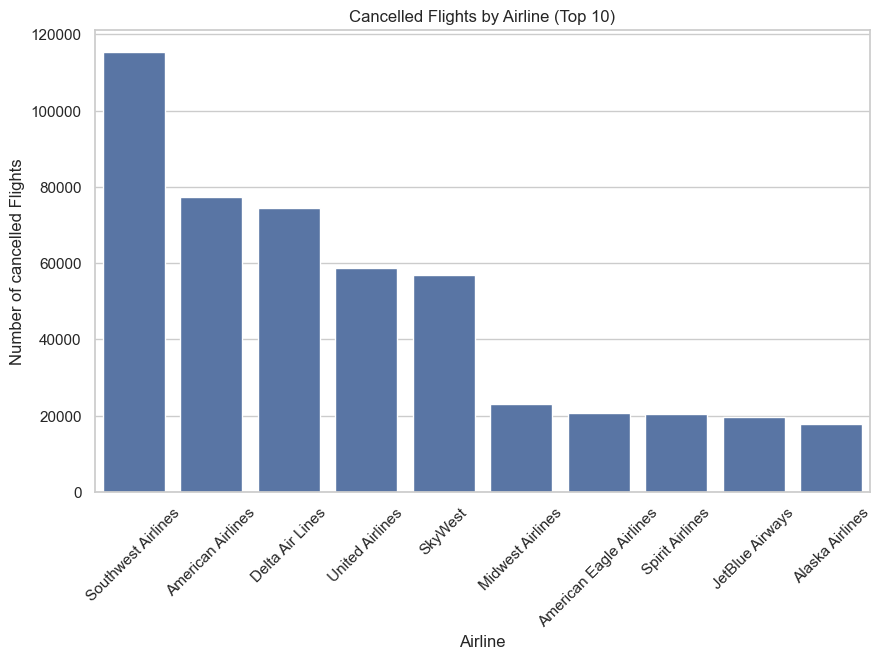

In [204]:
# Limit the dataframe to the first 10 rows
limited_df = cancel_table4.head(10)

# Set the plot style
sns.set(style="whitegrid")

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x="name", y="cancelled flights", data=limited_df)

# Add title and labels
plt.title("Cancelled Flights by Airline (Top 10)")
plt.xlabel("Airline")
plt.ylabel("Number of cancelled Flights")

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()

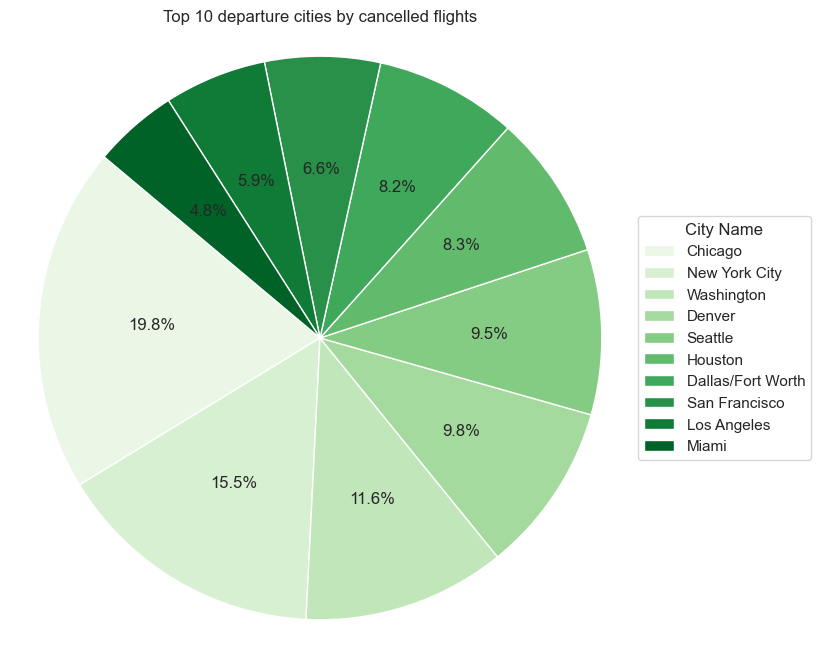

In [216]:
# Sort the pivot table by 'CANCELLED' in descending order and limit to top 10
top10_cancelled = cancel_city00.sort_values(by="CANCELLED", ascending=False).head(10)

# Extract the data for the pie chart
labels = top10_cancelled.index  # city_name is the index
sizes = top10_cancelled['CANCELLED']

# Generate a list of green shades
colors = sns.color_palette("Greens", n_colors=10)  # 10 shades of green

# Set the plot style
sns.set(style="whitegrid")

# Create the pie chart with green shades
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(sizes, colors=colors, autopct='%1.1f%%', startangle=140)

# Add a title
plt.title("Top 10 departure cities by cancelled flights")

# Add a legend to the side of the pie chart
plt.legend(wedges, labels, title="City Name", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Show the plot
plt.show()

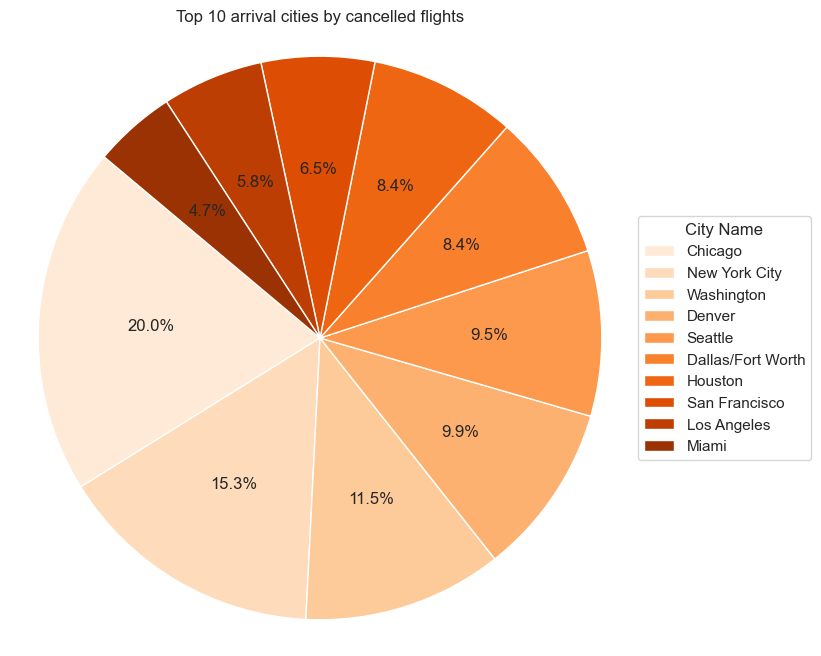

In [220]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the pivot table by 'CANCELLED' in descending order and limit to top 10
top10_cancelled_orange = cancel_city01.sort_values(by="CANCELLED", ascending=False).head(10)

# Extract the data for the pie chart
labels_orange = top10_cancelled_orange.index  # city_name is the index
sizes_orange = top10_cancelled_orange['CANCELLED']

# Generate a list of orange shades
colors_orange = sns.color_palette("Oranges", n_colors=10)  # 10 shades of orange

# Set the plot style
sns.set(style="whitegrid")

# Create the pie chart with orange shades
plt.figure(figsize=(8, 8))
wedges_orange, texts_orange, autotexts_orange = plt.pie(sizes_orange, colors=colors_orange, autopct='%1.1f%%', startangle=140)

# Add a title
plt.title("Top 10 arrival cities by cancelled flights")

# Add a legend to the side of the pie chart
plt.legend(wedges_orange, labels_orange, title="City Name", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Show the plot
plt.show()

In [96]:
flight["departure_delay"].value_counts(normalize=True).head(10).mul(100).round(1).astype(str) + '%'

0    74.7%
1    25.3%
Name: departure_delay, dtype: object

In [18]:
# Export cleaned tables as csv to be loaded to MySQL

#city
#city.to_csv('city.csv', index=False)  

#flight
#flight.to_csv('flight.csv', index=False)  

#airlines
#merge2.to_csv('airlines.csv', index=False)  